In [1]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt
from torch.fft import fft2

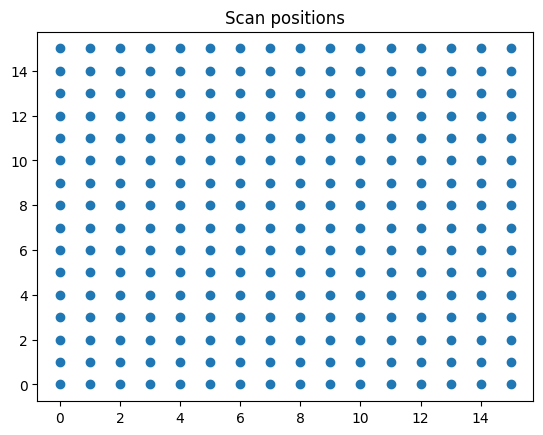

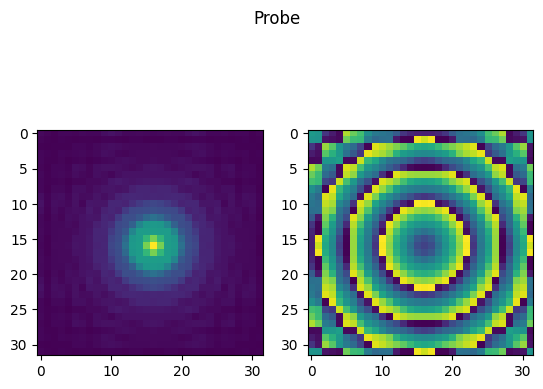

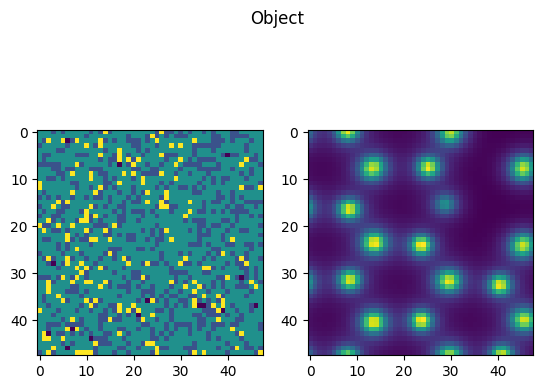

In [2]:
r = th.as_tensor(np.load('./r.npy'))
probe = th.as_tensor(np.load('./probe.npy'))
O = th.as_tensor(np.load('./object.npy'))

#%%

fig, ax = plt.subplots()
ax.scatter(r[:,0],r[:,1])
plt.title('Scan positions')
plt.show()
#%%
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(probe))
ax[1].imshow(np.angle(probe))
plt.suptitle('Probe')
plt.show()
#%%
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(O))
ax[1].imshow(np.angle(O))
plt.suptitle('Object')
plt.show()
#%%


In [3]:
print(r.shape)
print(probe.shape)
print(O.shape)

torch.Size([256, 2])
torch.Size([32, 32])
torch.Size([48, 48])


In [4]:
r[:, 0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 

In [5]:
intensities_list = []

for i in range(r.shape[0]):
    position = r[i, :]
    #print(position)

    # crop the images from different position to get 32 x 32
    H, W = probe.shape # 32
    cropped_image = O[position[0]:32 + position[0], position[1]:32 + position[1]]
    #print(cropped_image.shape)

    modulation_field = cropped_image * probe
    #print(modulation_field.shape)

    # far-field propagation
    far_field = fft2(modulation_field)

    # intensity
    intensity = far_field.abs()
    intensities_list.append(intensity)

intensities = th.stack(intensities_list, dim=0)
print(intensities.shape)

torch.Size([256, 32, 32])


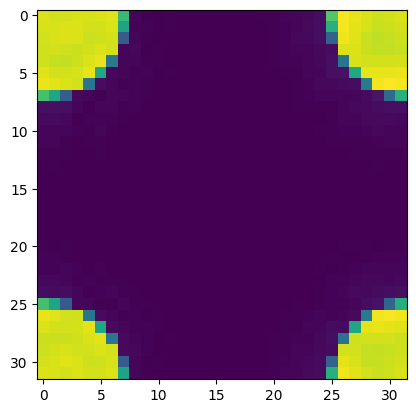

In [6]:
plt.imshow(intensities[0, :, :])

In [6]:
import torch.nn as nn
class scanning(nn.Module):
    def __init__(self, r, object_dim):
        super().__init__()
        self.r = r
        self.object_dim = object_dim
        self.object = th.nn.Parameter(
            th.ones(self.object_dim[0], self.object_dim[1], dtype=th.complex64), requires_grad=True
        )

    def forward(self, probe):
        
        intensities_list = []
        for i in range(self.r.shape[0]):
            position = self.r[i, :]
        
            # crop the images from different position to get 32 x 32
            H, W = probe.shape # 32
            cropped_image = self.object[position[0]:32 + position[0], position[1]:32 + position[1]]
            #print(cropped_image.shape)
        
            modulation_field = cropped_image * probe
            #print(modulation_field.shape)
        
            # far-field propagation
            far_field = fft2(modulation_field)
        
            # intensity
            intensity = far_field.abs()
            intensities_list.append(intensity)
            
        intensities = th.stack(intensities_list, dim=0)

        return intensities

In [7]:
forward_model = scanning(r, object_dim=[48, 48])

In [48]:
# optimization
forward_model = scanning(r, object_dim=[48, 48])

optimizer = th.optim.Adam(params=forward_model.parameters(), lr=1e-3)

loss = nn.MSELoss()

itrs = 1000

for itr in range(itrs):
    #print(itr)
    output = forward_model(probe)
    loss_value = loss(output, intensities)
    optimizer.zero_grad()

    loss_value.backward()
    optimizer.step()
    
    print(loss_value.item())    
    

0.21926312148571014
0.21176593005657196
0.20476843416690826
0.19782346487045288
0.19103099405765533
0.18443402647972107
0.17805621027946472
0.17191220819950104
0.16600993275642395
0.16035296022891998
0.1549425721168518
0.14977802336215973
0.14485640823841095
0.1401730328798294
0.13572178781032562
0.13149544596672058
0.1274857372045517
0.12368397414684296
0.12008124589920044
0.11666837334632874
0.113436259329319
0.1103757694363594
0.1074778363108635
0.10473347455263138
0.10213395953178406
0.09967075288295746
0.09733565896749496
0.09512066841125488
0.09301808476448059
0.09102071076631546
0.08912152796983719
0.08731381595134735
0.08559121191501617
0.08394771069288254
0.08237773180007935
0.080875925719738
0.07943730801343918
0.07805728912353516
0.0767313614487648
0.07545561343431473
0.07422621548175812
0.0730397030711174
0.07189285755157471
0.07078270614147186
0.06970641762018204
0.06866147369146347
0.06764548271894455
0.06665625423192978
0.06569177657365799
0.06475019454956055
0.063829943

In [50]:
output = forward_model.object.detach().numpy()

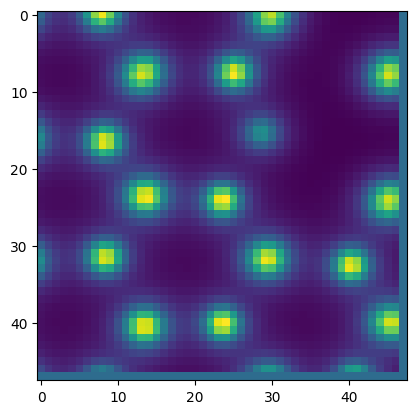

In [52]:
plt.imshow(np.angle(output))